In [1]:
using Distributions
using StatsPlots
default(titlefontsize=12)
using Roots
using Random
using StatsBase

In [2]:
name(dist::UnivariateDistribution) = replace(string(dist), r"{[^{.]*}"=>"")

function pmfordstat(dist, n, k, x)
    beta = Beta(k, n-k+1)
    cdf(beta, cdf(dist, x)) - cdf(beta, cdf(dist, x*(1 - eps())))
end

function cdfordstat(dist, n, k, x)
    beta = Beta(k, n-k+1)
    cdf(beta, cdf(dist, x))
end

pmfmedian(dist, n, x) = pmfordstat(dist, n, (n+1)/2, x)
cdfmedian(dist, n, x) = cdfordstat(dist, n, (n+1)/2, x)

empiricaldist(X) = DiscreteNonParametric(X, fill(1/length(X), length(X)))

function pvalmedian(X, a)
    n = length(X)
    sampledist = empiricaldist(X)
    min(1, 2cdfmedian(sampledist, n, a), 2(1 - cdfmedian(sampledist, n, a*(1 - eps()))))
end

function cimedian(X; α = 0.05)
    n = length(X)
    sampledist = empiricaldist(X)
    f(x) = cdfmedian(sampledist, n, x)
    m = median(X)
    L = find_zeros(x -> f(x) - α/2,       minimum(X), m)[begin]
    U = find_zeros(x -> f(x) - (1 - α/2), m, maximum(X))[end]
    L, U
end

function plot_randmedianci(dist, n; α = 0.05)
    X = rand(dist, n)
    sampledist = empiricaldist(X)
    a, b = minmax(median(dist), median(X))
    s = max(std(dist), std(X))/√n
    xlim = (min(a,b) - 5s, max(a,b) + 5s)
    ci = cimedian(X; α) |> collect
    plot(; legend=:topleft)
    plot!(x -> cdfmedian(dist, n, x), xlim...; label="true")
    plot!(x -> cdfmedian(sampledist, n, x), xlim...; label="bootstrap estimation")
    vline!([median(dist)]; label="true median", c=1, ls=:dash)
    vline!([median(X)]; label="sample median", c=2, ls=:dash)
    plot!(ci, fill(α, 2); label="confidence interval", c=:red, alpha=0.7, lw=3)
    plot!(; ytick=0:0.05:1)
    title!("$(name(dist)), n=$n")    
end

plot_randmedianci (generic function with 1 method)

In [3]:
pvalmedian(randn(10), 0)

0.5123897987357997

In [4]:
cimedian(randn(10))

(-0.5424278590383161, 0.8983886468199219)

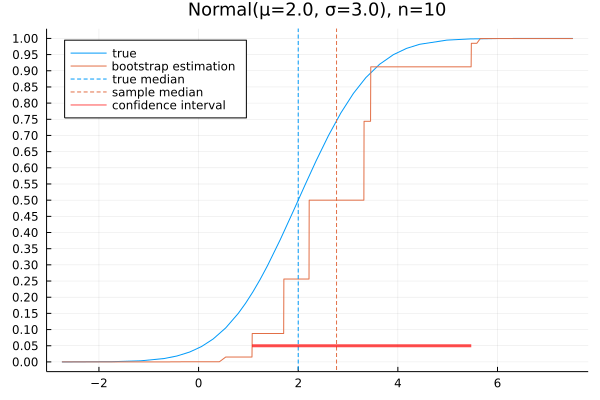

In [5]:
plot_randmedianci(Normal(2, 3), 10; α = 0.05)

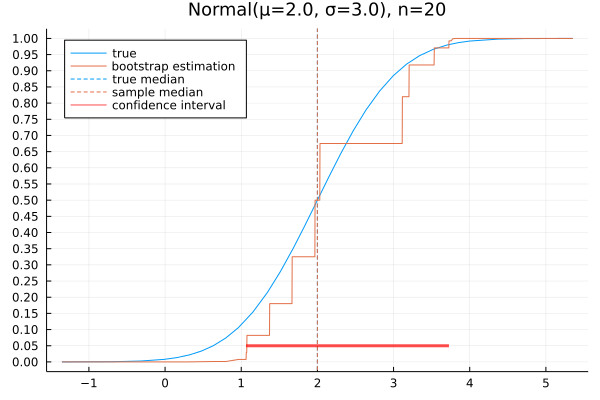

In [6]:
plot_randmedianci(Normal(2, 3), 20; α = 0.05)

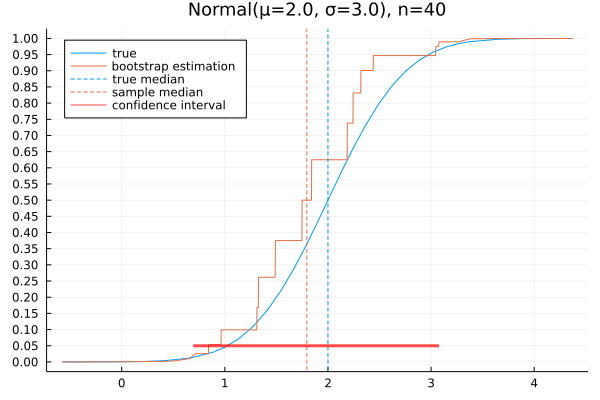

In [7]:
plot_randmedianci(Normal(2, 3), 40; α = 0.05)

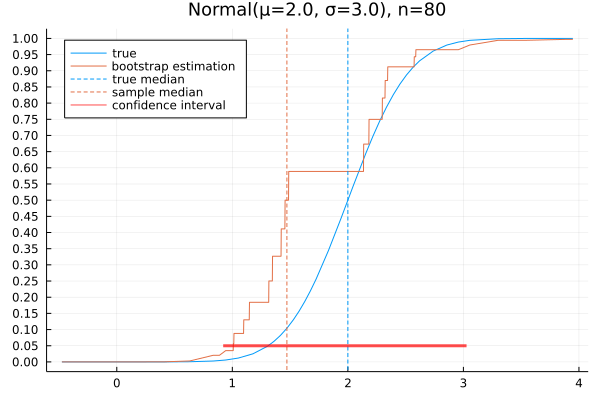

In [8]:
plot_randmedianci(Normal(2, 3), 80; α = 0.05)

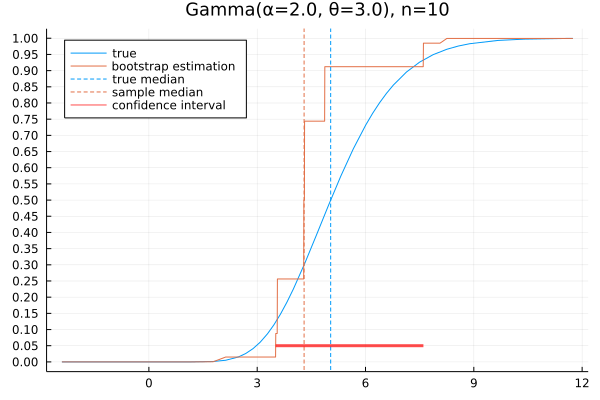

In [9]:
plot_randmedianci(Gamma(2, 3), 10; α = 0.05)

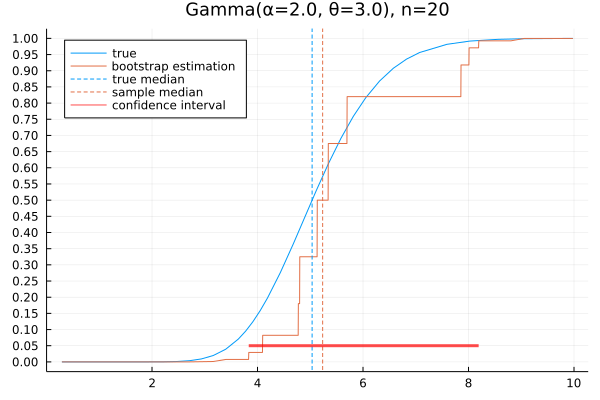

In [10]:
plot_randmedianci(Gamma(2, 3), 20; α = 0.05)

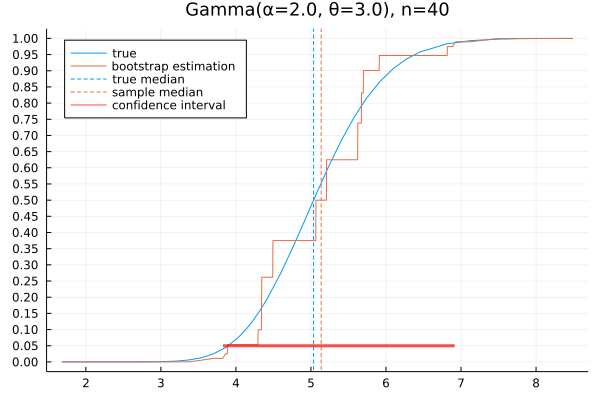

In [11]:
plot_randmedianci(Gamma(2, 3), 40; α = 0.05)

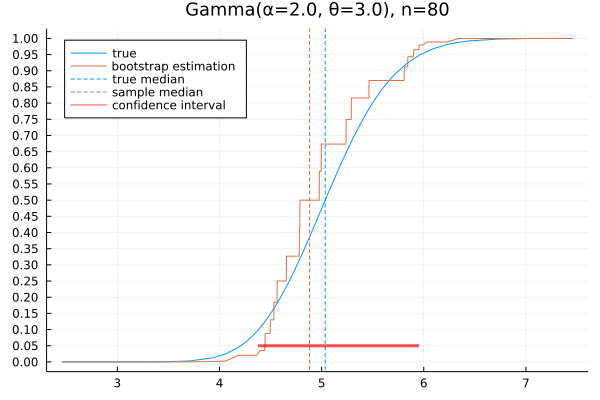

In [12]:
plot_randmedianci(Gamma(2, 3), 80; α = 0.05)

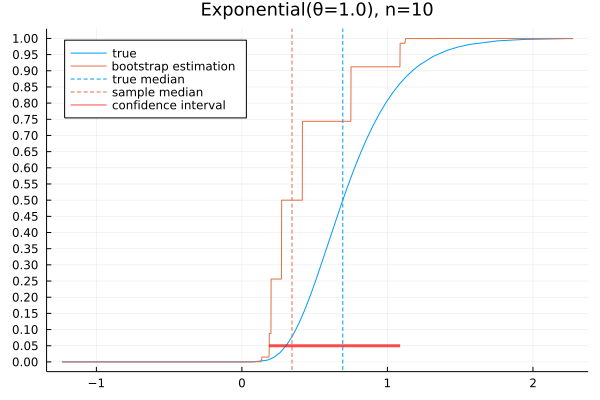

In [13]:
plot_randmedianci(Exponential(), 10; α = 0.05)

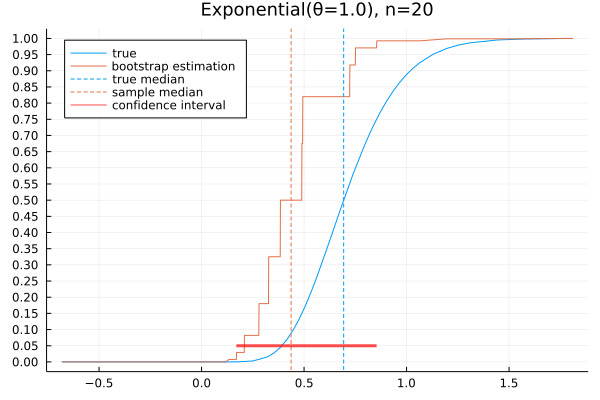

In [14]:
plot_randmedianci(Exponential(), 20; α = 0.05)

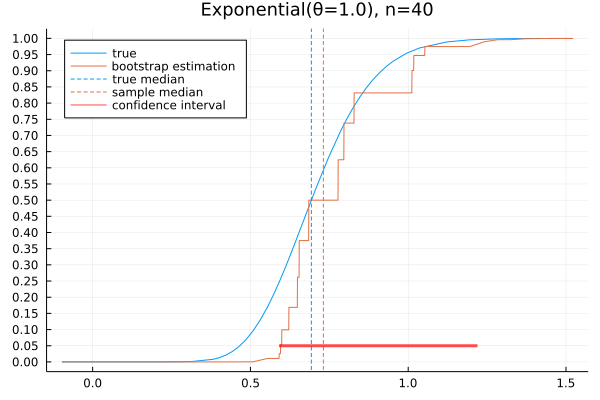

In [15]:
plot_randmedianci(Exponential(), 40; α = 0.05)

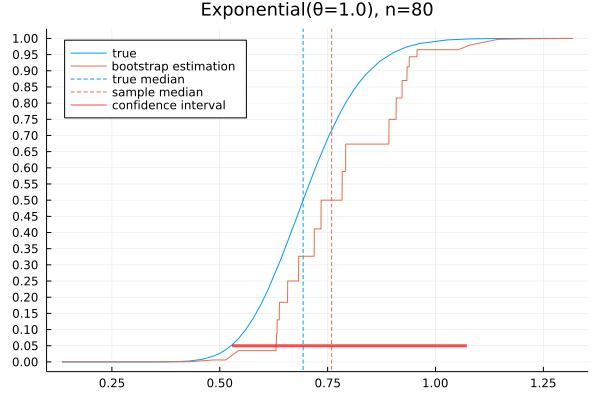

In [16]:
plot_randmedianci(Exponential(), 80; α = 0.05)

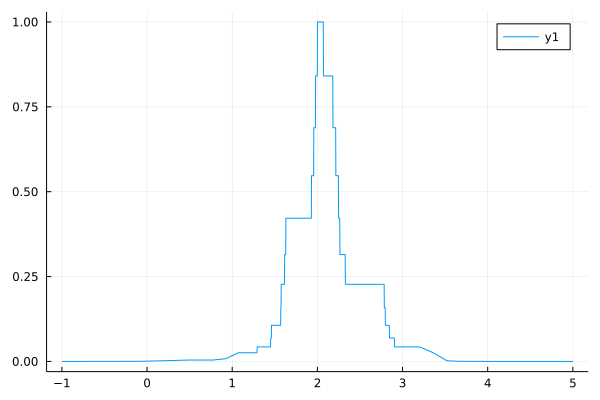

In [17]:
dist, n = Normal(2, 3), 100
X = rand(dist, n)
plot(x -> pvalmedian(X, x), -1, 5)

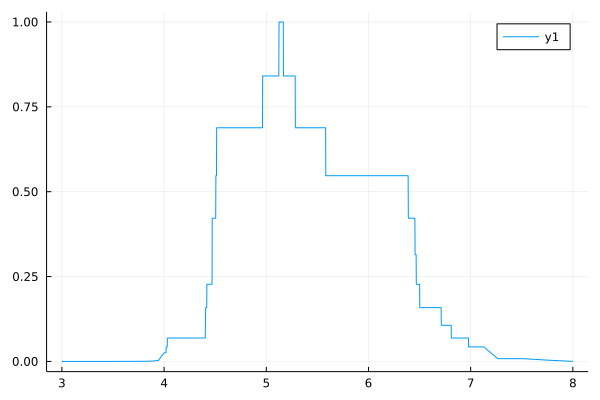

In [18]:
dist, n = Gamma(2, 3), 100
X = rand(dist, n)
plot(x -> pvalmedian(X, x), 3, 8)

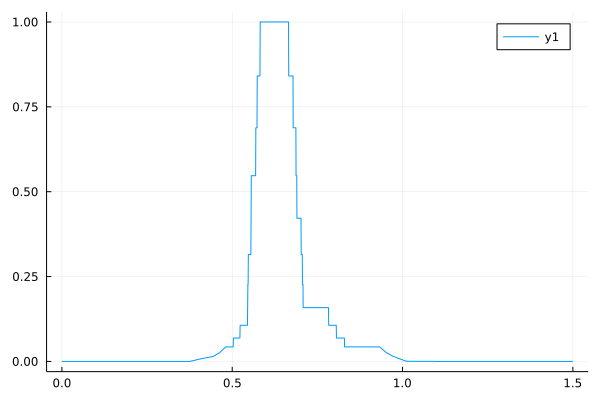

In [19]:
dist, n = Exponential(), 100
X = rand(dist, n)
plot(x -> pvalmedian(X, x), 0, 1.5)

In [20]:
function sim_mediantest(dist, n; L = 10^5)
    a = median(dist)
    pval = Vector{Float64}(undef, L)
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        pval[i] = pvalmedian(X, a)
    end
    pval
end

function plot_mediantest(dist, n; L = 10^5)
    pval = sim_mediantest(dist, n; L)
    m = median(dist)
    s = std(dist)/√n
    plot(; legend=false)
    plot!(a -> ecdf(pval)(a), 0, 0.1; label="ecdf of pvalues")
    plot!([0, 0.1], [0, 0.1]; label="", c=:black, ls=:dot)
    plot!(; xtick=0:0.01:1, ytick=0:0.01:1)
    plot!(; size=(400, 400))
end

plot_mediantest (generic function with 1 method)

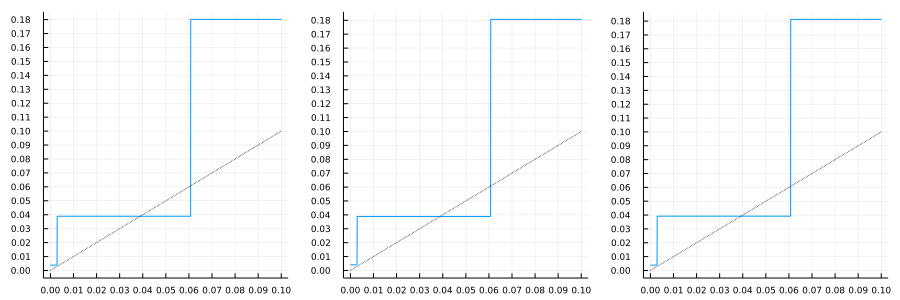

In [21]:
n = 9
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

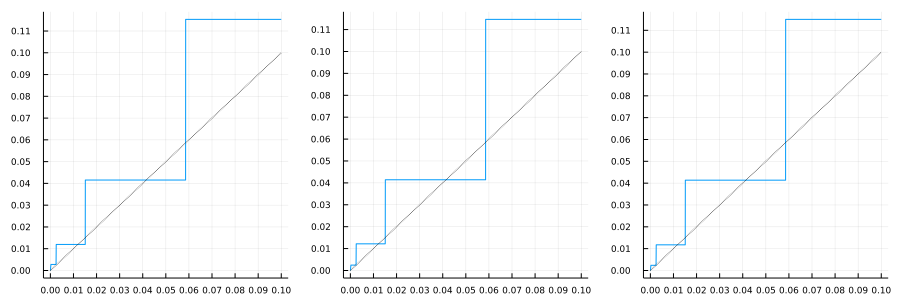

In [22]:
n = 20
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

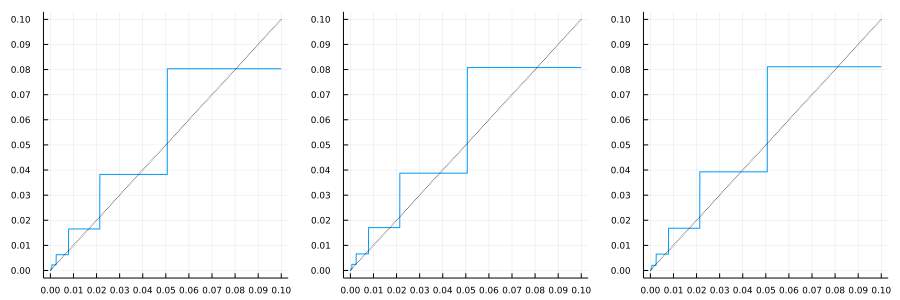

In [23]:
n = 40
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

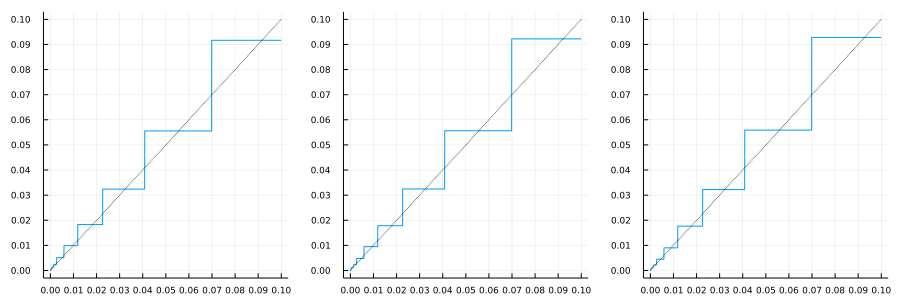

In [24]:
n = 80
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

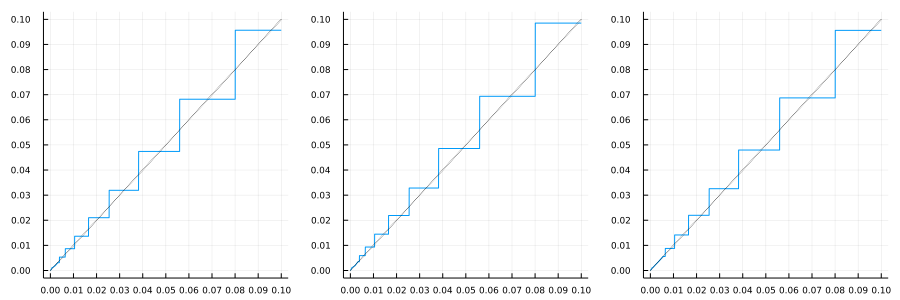

In [25]:
n = 160
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

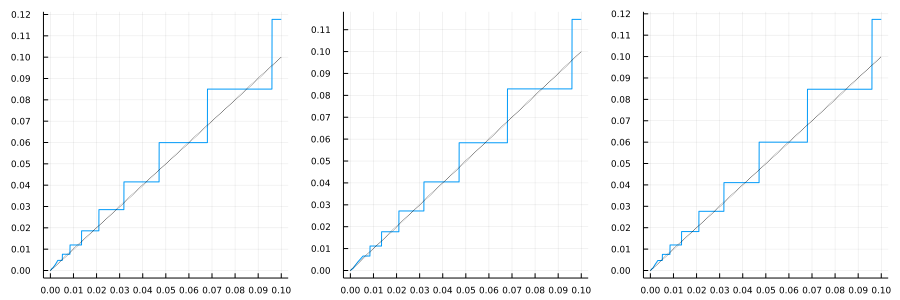

In [26]:
n = 161
P1 = plot_mediantest(Normal(2, 3), n)
P2 = plot_mediantest(Gamma(2, 3), n)
P3 = plot_mediantest(LogNormal(), n)
plot(P1, P2, P3; size=(900, 300), layout=(1, 3), tickfontsize=6)

観察: 第一種の過誤が起こる確率は母集団分布によらずに決まっている.

In [27]:
dist, n = Gamma(2, 3), 10
X = rand(dist, n)
Y = collect(1.0:n)
@show pval_X = pvalmedian.(Ref(X), sort(X))
@show pval_Y = pvalmedian.(Ref(Y), Y);
pval_X == pval_Y

pval_X = pvalmedian.(Ref(X), sort(X)) = [0.0010248294575877876, 0.03017079516557386, 0.1756515754750082, 0.5123897987357997, 0.9999999999999999, 1.0, 0.5123897987357997, 0.17565157547500831, 0.03017079516557386, 0.0010248294575876393]
pval_Y = pvalmedian.(Ref(Y), Y) = [0.0010248294575877876, 0.03017079516557386, 0.1756515754750082, 0.5123897987357997, 0.9999999999999999, 1.0, 0.5123897987357997, 0.17565157547500831, 0.03017079516557386, 0.0010248294575876393]


true

このように, 任意のサイズ $n$ のサンプル $X_1<X_2<\cdots<X_n$ から得られるP値函数の $X_i$ における値と, $1<2<\cdots<n$ から得られるP値函数の $i$ における値は等しくなる.